<h1> ch6 게이트가 추가된 RNN </h1>

<p>
    RNN은 순환 경로를 포함하며 과거의 정보를 기억할 수 있다. 하지만 성능은 좋지 않다. 왜냐하면, 시계열 데이터에서 시간적으로 멀리 떨어진, 장기 의존 관계를 잘 학습할 수 없기 때문이다. LSTM이나 GRU라는 계층을 좀더 자주 사용한다. LSTM이나 GRU에는 '게이트'라는 구조가 더해져 있다. 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있다. 
</p>

<h2> 6.1 RNN의 문제점 </h2>

<p>
    이전의 RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어렵다. 그 이유는 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다. 즉, 기울기가 점점 소실되거나, 기울기가 반대로 매우 큰 수로 증가한다. 
</p>

<h3> 6.1.1 RNN 복습 </h3>

<p>
    RNN 계층은 순환 경로를 가지고 있다. 시계열 데이터인 $\textbf{x}_t$를 입력하면 $\textbf{h}_t$를 출력한다. 이 $\textbf{h}_t$는 RNN 계층의 은닉 상태라고 하여, 과거 정보를 저장한다. RNN의 특징은 바로 이전 시각의 은닉 상태를 이용하는 점이다. RNN 계층의 순전파에서 수행하는 계산은 행렬의 곱과 합, 그리고 활성화 함수인 tanh 함수에 의한 변환으로 구성된다. 
</p>

<h3> 6.1.2 기울기 소실 또는 기울기 폭발 </h3>

<p>
    언어 모델은 주어진 단어들을 기초로 다음에 출현할 단어를 예측하는 일을 한다. RNN을 사용해 언어 모델을 구현했다. 기울기를 전달함으로썬 시간 방향의 의존 관계를 학습할 수 있다. 기울기는 학습해야 할 의미가 있는 정보가 들어 있다. 기울기가 중간에 적어지면 가중치 매개변수는 전혀 갱신되지 않게 된다. 
</p>

<h3> 6.1.3 기울기 소실과 기울기 폭발 원인 </h3>

<p>
    RNN 계층에서 기울기 소실이 일어나는 원인을 살펴본다. T번째 정답 레이블로부터 전해지는 기울기가 어떻게 변하는지 확인한다. 순전파에서는 'tanh', '+', 'MatMul' 연산을 통과하다는 것을 알 수 있다. '+'의 역전파는 상류에서 전해지는 기울기를 그대로 하류로 흘려보낼 뿐이다. 그래서 기울기는 변하지 않는다. $ y = tanh(x) $ 일 때의 미분은 $ \frac{\partial y}{\partial x} = 1 - y^2 $ 이다. 미분을 보면 1.0 값 이하이고, x가 0으로부터 멀어질수록 작아진다. 역전파에서 기울기가 tanh 노드를 지울 때마다 값은 계속 작아진다. 상류로부터 $\textbf{dh}$라는 기울기가 흘러온다고 가정한다. 이때 MatMul 노드에서 역전파는 $\textbf{dhW}_h^T$ 라는 행렬 곱으로 기울기를 계산한다. 여기서 주목할 점은 행렬 곱셈에서는 매번 똑같은 가중치인 $\textbf{W}_h$가 사용된다.
</p>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 2  # 미니배치 크기
H = 3  # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

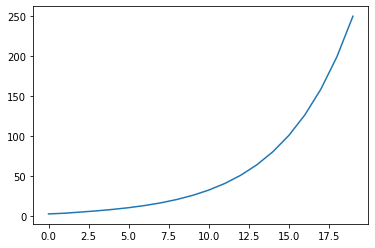

In [4]:
plt.plot(norm_list)

<p>
    시간에 비례해 지수적으로 증가함을 알 수 있다. 이것이 기울기 폭발이다.
</p>

In [5]:
dh = np.ones((N, H))
Wh_2 = np.random.randn(H, H) * 0.5

norm_list_2 = []
for t in range(T):
    dh = np.matmul(dh, Wh_2.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list_2.append(norm)

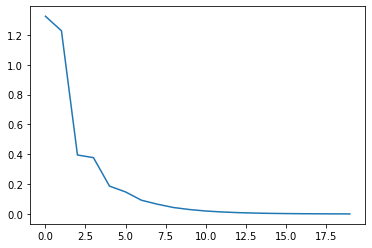

In [6]:
plt.plot(norm_list_2)

<p>
    이번에는 기울기가 지수적으로 감소한다. 이것이 기울기 소실이다. 기울기 소실이 일어나면 기울기가 매우 빠르게 작아진다. 기울기가 일정 수준 이하로 작아지면 가중치 매개변수가 더 이상 갱신되지 않는다. 장기 의존 관계를 학습할 수 없게 된다. 지금까지의 실험에서 기울기의 크기는 지수적으로 증가하거나, 감소한다. 행렬 Wh를 T번 반복해서 곱했기 때문이다. 
</p>

<h3> 6.1.4 기울기 폭발 대책 </h3>
<p>
    기울기 폭발의 대책으로는 전통적인 기법인 기울기 클리핑이 있다. 기울기 클리핑은 매우 단순하다
    $$
        if \space \lVert \widehat{g} \rVert \geq \textit{threshold} :  \\
        \widehat {g} = \frac {\textit{threshold}}{\lVert \widehat{g} \rVert} \widehat{g} 
    $$
    신경망에서 사용되는 모든 매개변수에 대한 기울기를 $ \mathbf{\widehat{g}} $ 하나로 처리한다고 가정한다. 그리고 threshold를 문턱값으로 설정한다. 이때 기울기의 L2 노름이 문턱값을 초과하면 두번째 줄의 수식과 같이 기울기를 수정한다. 즉 threshold를 설정하여 넘을 때마다 수정한다. 
</p>

In [7]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1: # threshold  = 1
        for grad in grads:
            grad *= rate

<h2> 6.2 기울기 소실과 LSTM </h2>

<p>
    RNN 학습에서는 기울기 소실도 큰 문제이다. 이 문제를 해결하려면 RNN 계층의 아키텍처를 근본부터 뜯어고쳐야 한다. 게이트가 추가된 RNN으로 많은 아키텍쳐(신경망 구성)가 제안되었다. 대표적으로 LSTM과 GRU가 있다. 
</p>

<h3> 6.2.1 LSTM의 인터페이스 </h3>

<p>
    LSTM 계층의 인터페이스에는 c라는 경로가 있다. c를 기억 셀이라 하며, LSTM 전용의 기억 메커니즘이다. 기억 셀의 특징은 데이터를 자기 자신으로만 주고 받는다. LSTM 계층 내에서만 완결되고, 다른 계층으로 출력하지 않는다. 
</p>

<h3> 6.2.2 LSTM 계층 조립하기 </h3>

<p>
    LSTM에는 기억 셀 $\mathbf{c_t}$ 가 있다. 이 $mathbf{c_t}$ 에는 시각 t에서의 LSTM의 기억이 저장되어 있는데, 과거로부터 시각 t까지의 필요한 정보가 저장되어 있다고 가정한다. 필요한 정보를 모두 간직한 이 기억을 바탕으로 외부 계층에 은닉 상태 $\mathbf{h_t}$를 출력한다. 현재의 기억 셀 $\mathbf{c_t}$ 는 3개의 입력 $ (\mathbf{c_{t-1}}, \mathbf{h_{t-1}}, \mathbf{x_t})$로부터 '어떤 계산'을 수행하여 구한다. 갱신된 $\mathbf{c_t}$를 사용해 은닉 상태 $\mathbf{h_t}$를 계산한다는 것이다. 
</p>

<p>
    게이트의 기능은 데이터의 흐름을 제어한다. 물의 흐름을 멈추거나 배출하는 것이 게이트의 역활이다. 댐과 같은 역활을 한다. 얼마나 데이터를 배출할지 제어한다. LSTM에서 사용하는 '열기/닫기' 뿐 아니라, 어느 정도로 열지 조절한다. 즉, 0.7이나 0.2처럼 제어할 수 있다. 게이트의 열림 상태는 0.0~1.0 사이의 실수로 나타낸다. 데이터 흐름을 제어하는 것도 데이터로 부터 자동으로 학습한다.
</p>

<h3> 6.2.3 output 게이트 </h3>

<p>
    이번 절에서는 $tanh(\mathbf{c_t})$에 게이트를 적용하는 걸 생각한다. $tanh(\mathbf{c_t})$의 각 원소에 대해 '이것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정한다. 이 게이트는 다음 은닉 상태 $\mathbf{h_t}$의 출력을 담당하는 게이트이다. output 게이트의 열림 상태는 입력 $\mathbf{x_t}$와 이전 상태 $\mathbf{h_{t-1}}$로부터 구한다. 
    $$
        \mathbf{o} = \sigma(\mathbf{x_tW_x^{(o)}} + \mathbf{h_{t-1}W_h^{(o)}} + b^{(o)})
    $$
    행렬들의 곱과 편향 $\mathbf{b^{(o)}}$를 모두 더한 다음 시그모이드 함수를 거쳐 출력 게이트의 출력 $\mathbf{o}$를 구한다. 마지막으로 $\mathbf{o}$와 $tanh(\mathbf{c_t})$의 원소별 곱을 $\mathbf{h_t}$로 출력한다. 원소별 곱을 아다마르 곱이라고 한다. 아다마르 곱을 기호로 $\odot$ 으로 나타낸다. 
    $$
        \mathbf{h_t} = \mathbf{o} \odot tanh(\mathbf{c_t})
    $$
</p>

<h3> 6.2.4 forget 게이트 </h3>

<p>
    기억 셀이 '무엇을 잊을까'를 명확하게 지시해야 한다. $\mathbf{c_{t-1}}$의 기억 중에서 불 필요한 기억을 잊게하는 게이트를 추가한다. 이를 <strong>forget 게이트</strong>라고 한다. forget 게이트를 LSTM 계층에 추가한다.
    $$
        \mathbf{f} = \sigma (\mathbf{x_t W_x^{(f)} + h_{t-1}W_h^{(f)} + b^{(f)}}) \
    $$
    forget 게이트의 출력 $\mathbf{f}$가 구해진다. 그리고 $\mathbf{f}$와 이전 기억 셀 $\mathbf{c_{t-1}}$과의 원소별 곱, 즉 $\mathbf{c_t} = \mathbf{f} \odot \mathbf{c_{t-1}}$을 계산하여 $\mathbf{c_t}$를 구한다. 
</p>

<h3> 6.2.5 새로운 기억 셀 </h3>

<p>
    forget 게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제되었다. 이 상태에서 새로 기억할 정보를 기억 셀에 추가해야 한다. 여기서 tanh 노드를 추가한다. tanh 노드가 계산한 결과가 이전 시각의 기억 셀 $\mathbf{c_{t-1}}$에 더해진다. 기억 셀에 새로운 '정보'가 추가된다. '게이트'가 아니며, 새로운 '정보'를 기억 셀에 추가하는 것이 목적이다. 
    $$
        \mathbf{g} = tanh(\mathbf{x_t W_x^{(g)} + h_{t-1}W_h^{(g)} + b^{(g)}})
    $$
    새로운 기억을 $\mathbf{g}$ 로 표기한다. $\mathbf{g}$가 이전 시각의 기억 셀인 $\mathbf{c_{t-1}}$에 더해서 새로운 기억을 생성한다.
</p>

<h3> 6.2.6 input 게이트 </h3>

<p>
    마지막으로 $\mathbf{g}$에 게이트를 하나 추가한다. 여기에서 새롭게 추가하는 게이트를 input 게이트라고 한다. input 게이트는 $\mathbf{g}$의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다. 새 정보를 적절하게 취사선택하는 것이 이 게이트의 역활이다. 
    $$
        \mathbf{i} = \sigma ( \mathbf{x_tW_x^{(i)} + h_{t-1}W_h^{(i)} + b^{(i)}}) \
    $$
</p>

<h3> 6.2.7 LSTM의 기울기 흐름 </h3>

<p>
    기억 셀 $\mathbf{c}$의 흐름을 보면 'X' 와 '+'노드 만 지나간다. '+' 노드의 역전파는 기울기를 그대로 흘릴 뿐이여서 기울기 변화가 일어나지 않는다. 남는 것은 'X' 노드 인데 이 노드는 '행렬 곱' 이 아니라 '원소별 곱(아마다르 곱)'을 계산한다. 매번 새로운 게이트를 이용하여 원소별 곱을 하기 때문에 기울기 소실이 일어나기 어렵다. 
</p>

<h2> 6.3 LSTM 구현 </h2>

<p>
    최초 한 단계만 처리하는 LSTM 클래스를 구현한 다음, Time LSTM 클래스 구현한다.
</p>


In [2]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads  = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

<h3> 6.3.1 Time LSTM 구현 </h3>

In [3]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] = grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
        

<h2> 6.4 LSTM을 사용한 언어 모델 </h2>


In [4]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W,  affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name="Rnnlm.pkl"):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9998.81
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 2618.79
| 에폭 1 |  반복 41 / 1327 | 시간 5[s] | 퍼플렉서티 1234.97
| 에폭 1 |  반복 61 / 1327 | 시간 8[s] | 퍼플렉서티 972.01
| 에폭 1 |  반복 81 / 1327 | 시간 11[s] | 퍼플렉서티 807.54
| 에폭 1 |  반복 101 / 1327 | 시간 14[s] | 퍼플렉서티 675.95
| 에폭 1 |  반복 121 / 1327 | 시간 17[s] | 퍼플렉서티 636.72
| 에폭 1 |  반복 141 / 1327 | 시간 20[s] | 퍼플렉서티 605.94
| 에폭 1 |  반복 161 / 1327 | 시간 23[s] | 퍼플렉서티 581.31
| 에폭 1 |  반복 181 / 1327 | 시간 25[s] | 퍼플렉서티 587.67
| 에폭 1 |  반복 201 / 1327 | 시간 28[s] | 퍼플렉서티 496.81
| 에폭 1 |  반복 221 / 1327 | 시간 31[s] | 퍼플렉서티 488.88
| 에폭 1 |  반복 241 / 1327 | 시간 34[s] | 퍼플렉서티 446.79
| 에폭 1 |  반복 261 / 1327 | 시간 37[s] | 퍼플렉서티 456.25
| 에폭 1 |  반복 281 / 1327 | 시간 40[s] | 퍼플렉서티 437.22
| 에폭 1 |  반복 301 / 1327 | 시간 43[s] | 퍼플렉서티 394.39
| 에폭 1 |  반복 321 / 1327 | 시간 46[s] | 퍼플렉서티 345.99
| 에폭 1 |  반복 341 / 1327 | 시간 48[s] | 퍼플렉서티 400.99
| 에폭 1 |  반복 361 / 1327 | 시간 51[s] | 퍼플렉서티 410.31
| 에폭 1 |  반복 381 / 1327 | 시간 54[s] | 퍼플렉서티 335.31
| 에폭 1 

| 에폭 3 |  반복 561 / 1327 | 시간 460[s] | 퍼플렉서티 118.01
| 에폭 3 |  반복 581 / 1327 | 시간 463[s] | 퍼플렉서티 104.70
| 에폭 3 |  반복 601 / 1327 | 시간 466[s] | 퍼플렉서티 147.47
| 에폭 3 |  반복 621 / 1327 | 시간 469[s] | 퍼플렉서티 140.95
| 에폭 3 |  반복 641 / 1327 | 시간 472[s] | 퍼플렉서티 128.37
| 에폭 3 |  반복 661 / 1327 | 시간 475[s] | 퍼플렉서티 120.27
| 에폭 3 |  반복 681 / 1327 | 시간 478[s] | 퍼플렉서티 98.46
| 에폭 3 |  반복 701 / 1327 | 시간 480[s] | 퍼플렉서티 118.35
| 에폭 3 |  반복 721 / 1327 | 시간 483[s] | 퍼플렉서티 125.46
| 에폭 3 |  반복 741 / 1327 | 시간 486[s] | 퍼플렉서티 107.04
| 에폭 3 |  반복 761 / 1327 | 시간 489[s] | 퍼플렉서티 103.71
| 에폭 3 |  반복 781 / 1327 | 시간 492[s] | 퍼플렉서티 104.86
| 에폭 3 |  반복 801 / 1327 | 시간 495[s] | 퍼플렉서티 113.16
| 에폭 3 |  반복 821 / 1327 | 시간 498[s] | 퍼플렉서티 116.80
| 에폭 3 |  반복 841 / 1327 | 시간 500[s] | 퍼플렉서티 115.07
| 에폭 3 |  반복 861 / 1327 | 시간 503[s] | 퍼플렉서티 120.07
| 에폭 3 |  반복 881 / 1327 | 시간 506[s] | 퍼플렉서티 106.48
| 에폭 3 |  반복 901 / 1327 | 시간 509[s] | 퍼플렉서티 130.95
| 에폭 3 |  반복 921 / 1327 | 시간 512[s] | 퍼플렉서티 117.99
| 에폭 3 |  반복 941 / 1327 | 시간 515

C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from c

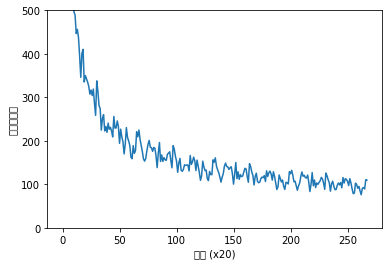

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  133.88053065359006


In [5]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 35    # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
           eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

model.save_params()

<h2> 6.5 RNNLM 추가 개선 </h2>


<h3> 6.5.1 LSTM 계층 다층화 </h3>

<p>
    RNNLM으로 정확한 모델을 만들려면 LSTM 계층을 깊게 쌓아 효과를 볼 수 있다. 여러 겹을 쌓으면 모델의 정확도가 향상되리라 기대할 수 있다. 문제의 복잡도나 준비된 학습 데이터의 양에 따라 층 수를 결정해야 한다.
</p>

<h3> 6.5.2 드롭아웃에 의한 과적합 억제 </h3>

<p>
    LSTM 계층을 다층화하면서 표현력이 풍부한 모델을 만들 수 있지만, 과적합을 일으킨다. RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킬 수 있다. 과적합을 억제하는 전통적인 방법에는 '훈련 데이터의 양 늘리기'와 '모델의 복잡도 줄이기', '정규화'가 있다. L2 정규화는 가중치가 너무 커지면 페널티를 부과한다. 드롭아웃 처럼 훈련시 계층 내의 뉴런 몇개를 무작위로 무시하는 학습 방법도 일종의 정규화라고 할 수 있다. 
</p>

<h3> 6.5.3 가중치 공유 </h3>

<p>
    언어 모델을 개선하는 아주 간단한 트릭 중 가중치 공유가 있다. Embedding 계층의 가중치와 Affine 계층의 가중치를 연결하는 기법이 가중치 공유이다. 두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상된다. 
</p>

<h3> 6.5.4 개선된 RNNLM 구현 </h3>

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,
                hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 세가지 개선!
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # 가중치 공유
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
        def predict(self, xs, train_flg=Flase):
            for layer in self.drop_layers:
                layer.train_flg = train_flg
            for layer in self.layers:
                xs = layer.forward(xs)
            return xs
        
        def forward(self, xs, ts, train_flg=True):
            score = self.predict(xs, train_flg)
            loss = self.loss_layer.forward(score, ts)
            return loss
        
        def backward(self, dout=1):
            dout = self.loss_layer.backward(dout)
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            return dout
        
        def reset_state(self):
            for layer in self.lstm_layers:
                layer.reset_state()
            
        

In [ ]:
import sys
sys.path.append('..')
from common import config
# config.GPU = True
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from better_rnnlm import BetterRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
               time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    
    print('검증 퍼플렉서티: ', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
        
    model.reset_state()
    print('-' * 50)

| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 10000.17
| 에폭 1 |  반복 21 / 1327 | 시간 24[s] | 퍼플렉서티 4724.68
| 에폭 1 |  반복 41 / 1327 | 시간 47[s] | 퍼플렉서티 1904.49
| 에폭 1 |  반복 61 / 1327 | 시간 70[s] | 퍼플렉서티 1320.11
| 에폭 1 |  반복 81 / 1327 | 시간 93[s] | 퍼플렉서티 1006.02
| 에폭 1 |  반복 101 / 1327 | 시간 116[s] | 퍼플렉서티 788.41
